In [59]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os

from model import *
from utils import *

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [60]:
use_cuda = torch.cuda.is_available()
device = get_device()

cpu


In [61]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

torch.manual_seed(1)
batch_size = 32
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model. 
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
# test till help to check accuracy of our model


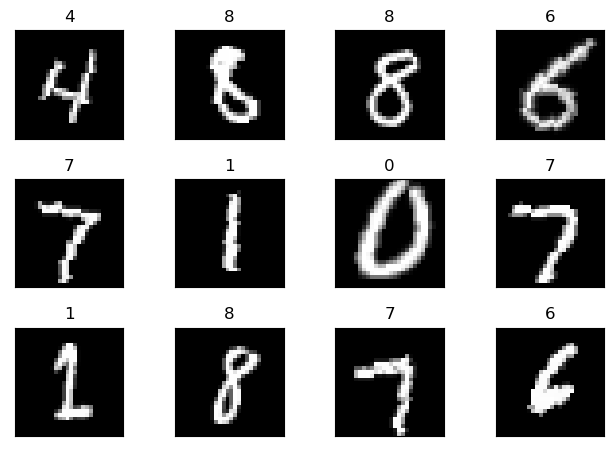

In [62]:
return_dataset_images(train_loader,12)

In [63]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def train(model, device, train_loader, optimizer):
  model.train()
  # here we are using the train component of the model
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # here above we are looping through each batch represented by batch id (like 4th batch, 5th batch, etc) and data is images of batch and target is the label  
    data, target = data.to(device), target.to(device)
    # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
    optimizer.zero_grad()
    # When we do back propagation, the gradients will be stored at one place and we need to initiate gradients as zero to begin withwhich is done in this step
    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    # The loss is sent to backpropagation and here the gradients are computed based on the loss
    optimizer.step()
    # Applying the gradients to the parameters
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader):
    model.eval()
    # here we are involking the evaluation method of the model object
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Here we are looping through the images and labels in the test dataset
            data, target = data.to(device), target.to(device)
            # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
            output = model(data)
            # we are sending model output to output variable
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
            # We are also summing up batch loss
            correct += GetCorrectPredCount(output, target)
            # Summing up the correct predictions

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [64]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

In [65]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)

for epoch in range(1, 2):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.2963 Batch_id=1874 Accuracy=56.82: 100%|██████████| 1875/1875 [09:39<00:00,  3.24it/s]


Test set: Average loss: 1.1440, Accuracy: 6067/10000 (60.67%)

Adjusting learning rate of group 0 to 1.0000e-02.


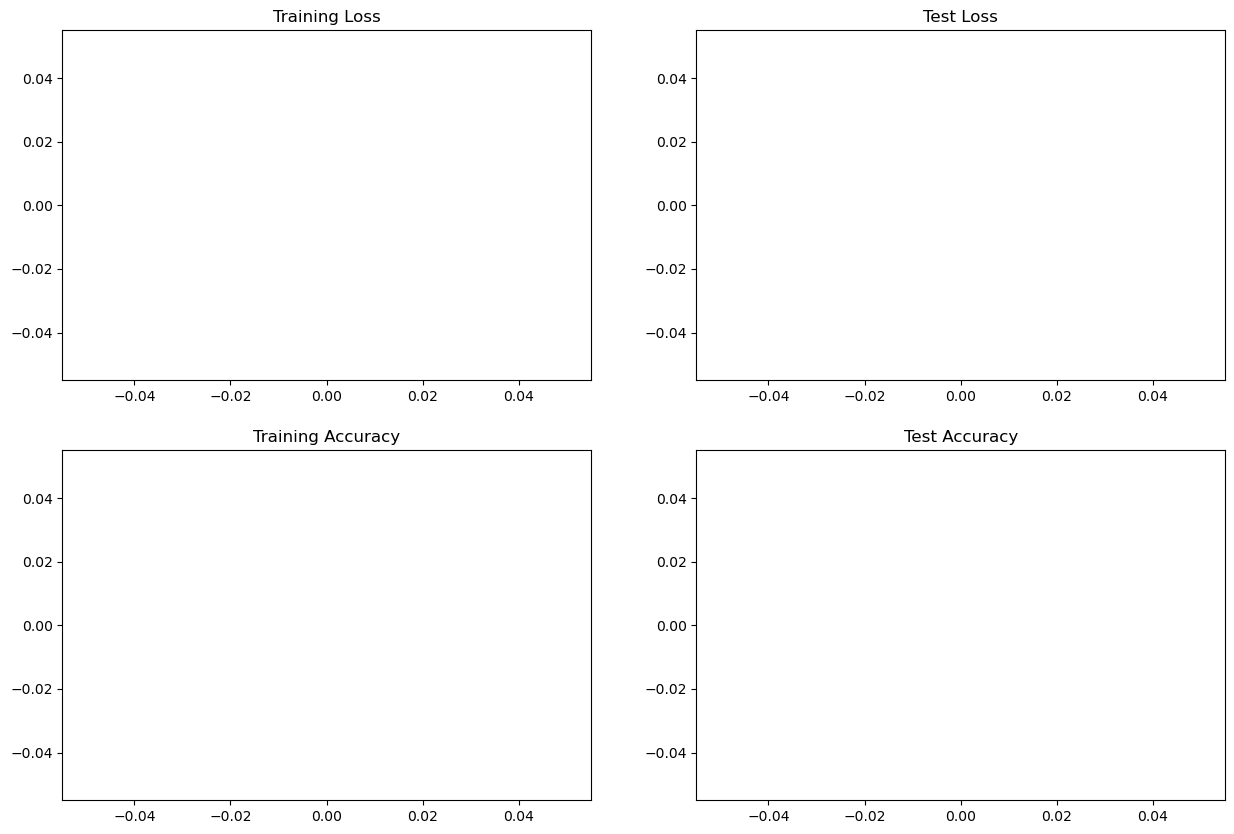

In [66]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)